In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn import model_selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
import cmath
import random

import tensorflow as tf
from tensorflow import keras
import sklearn
print(sklearn.__version__)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

%matplotlib inline


data = pd.read_csv("qsar_processed.csv")

# Functions

def variance_inflation(df):
    ## Calculate variance inflation factors
    X = df.copy()
    categorical = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    if len(categorical) > 0:
        dummies = pd.get_dummies(X, columns = categorical, drop_first=True)
        cols = dummies.columns
        print("dummies columns: %s" % cols)
        Xc = sm.add_constant(dummies)
        vifs = [vif(Xc.values, i) for i in range(Xc.shape[1])]
        vifs_ranked = pd.DataFrame(vifs, columns=['VIF'])#.sort_values(by='VIF', ascending=False)

        no_constant = vifs_ranked.drop(0, axis=0).reset_index(drop='index')
        no_constant['cols'] = cols
        print(no_constant.sort_values(by='VIF', ascending=False))
    else:
        cols = X.columns
        Xc = sm.add_constant(X)
        vifs = [vif(Xc.values, i) for i in range(Xc.shape[1])]
        vifs_ranked = pd.DataFrame(vifs, columns=['VIF'])#.sort_values(by='VIF', ascending=False)

        no_constant = vifs_ranked.drop(0, axis=0).reset_index(drop='index')
        no_constant['cols'] = cols
        print(no_constant.sort_values(by='VIF', ascending=False))
        
        

0.20.3


Index(['XLogP', 'MW', 'LipinskiFailures', 'nRotB', 'nAtomLAC', 'nAtomP',
       'nBase', 'ALogP', 'nAcid', 'nSmallRings', 'nRings5', 'nRings7',
       'tpsaEfficiency', 'WTPT.3', 'WTPT.5', 'topoShape', 'geomShape',
       'MDEC.11', 'MDEC.12', 'MDEC.13', 'MDEC.24', 'MDEC.33', 'MDEC.34',
       'MDEC.44', 'MDEO.11', 'MDEO.12', 'MDEO.22', 'MDEN.22', 'MDEN.23',
       'khs.dCH2', 'khs.ssCH2', 'khs.dsCH', 'khs.dssC', 'khs.aaaC', 'khs.sNH2',
       'khs.ssNH', 'khs.dsN', 'khs.aaN', 'khs.sssN', 'khs.sOH', 'khs.dO',
       'khs.aaO', 'khs.sF', 'khs.dsssP', 'khs.dS', 'khs.aaS', 'khs.ddssS',
       'khs.sCl', 'khs.sBr', 'FMF', 'SC.3', 'SC.4', 'SC.6', 'SCH.6', 'C1SP2',
       'C1SP3', 'C4SP3', 'ATSc4', 'ATSc5', 'Wlambda1.unity', 'Wlambda2.unity',
       'Wnu1.unity', 'Weta1.unity', 'Weta2.unity', 'Weta3.unity', 'WD.unity',
       'BCUTw.1l', 'BCUTc.1l', 'BCUTc.1h', 'BCUTp.1l', 'PNSA.1', 'PNSA.3',
       'RPCG', 'RPCS', 'RNCS', 'y_var'],
      dtype='object')


/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


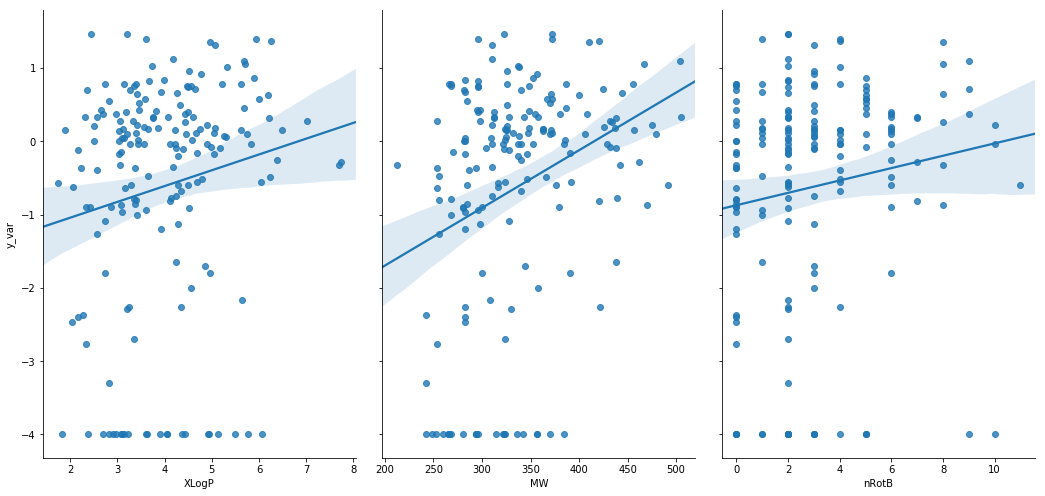

            VIF              cols
65          inf          WD.unity
64          inf       Weta3.unity
63          inf       Weta2.unity
62          inf       Weta1.unity
1   1031.743402                MW
13   500.692269            WTPT.3
9    269.181046       nSmallRings
3    225.684618             nRotB
40   216.624067            khs.dO
14   207.902544            WTPT.5
50   202.397498              SC.3
53   180.128393             SCH.6
12   169.891246    tpsaEfficiency
10   102.800936           nRings5
39    98.874949           khs.sOH
38    92.114305          khs.sssN
21    89.511043           MDEC.33
49    88.072493               FMF
26    87.016334           MDEO.22
22    83.585507           MDEC.34
25    80.456556           MDEO.12
68    68.958879          BCUTc.1h
30    68.954187         khs.ssCH2
61    64.867899        Wnu1.unity
72    63.742647              RPCG
59    62.331813    Wlambda1.unity
51    60.470519              SC.4
0     57.585828             XLogP
19    50.44617

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [3]:
## Feature Analysis
print(data.columns)

y_var = data['y_var']
sns.pairplot(data, x_vars=['XLogP','MW','nRotB'], y_vars='y_var', size=7, aspect=0.7, kind='reg')
plt.show()

variance_inflation(data)

In [4]:
# Feature set should include all columns except for the label y 
data.drop(columns=['y_var'], axis=1, inplace=True)
y_arr = np.array(y_var)
y = y_arr.reshape(-1,1)
X = np.array(data)

## Train and test set split 
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size=0.2, random_state=0)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test", y_test.shape)


X_train:  (143, 75)
X_test:  (36, 75)
y_train:  (143,)
y_test (36,)


Average MSE for linear regression model: 8.008 (+/- 4.793)
Average R2 for linear regression model: -2.385 (+/- 1.944)


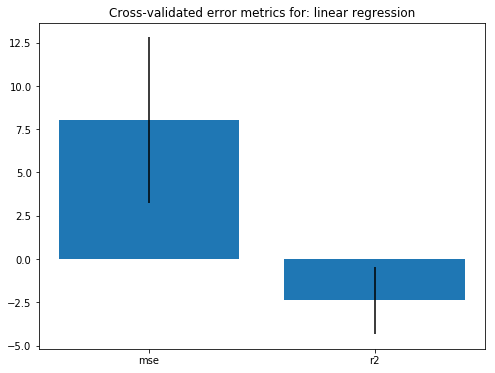

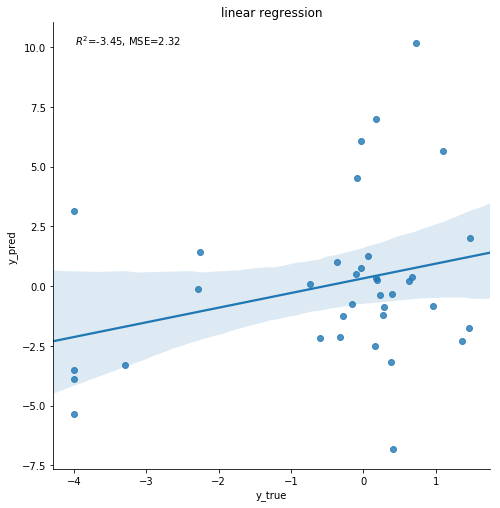

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


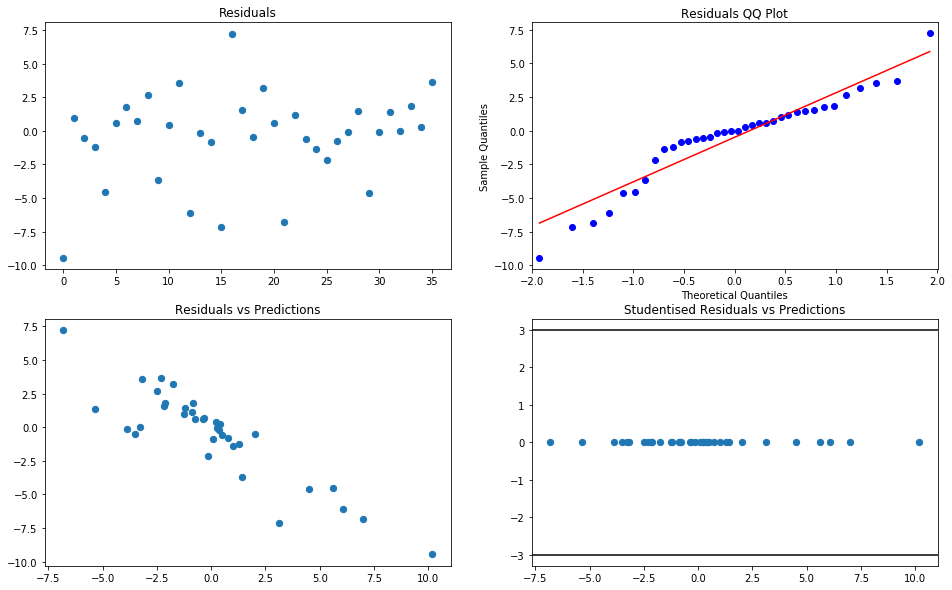

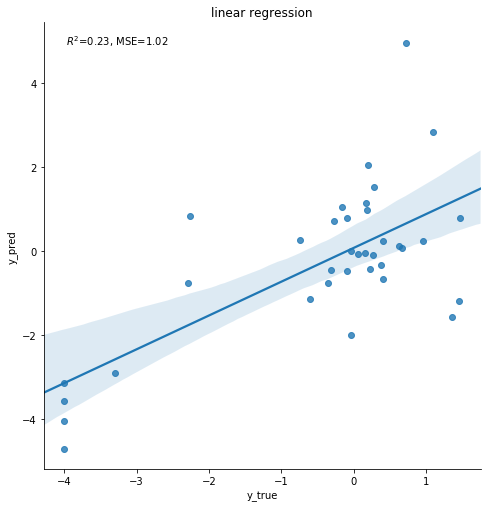

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


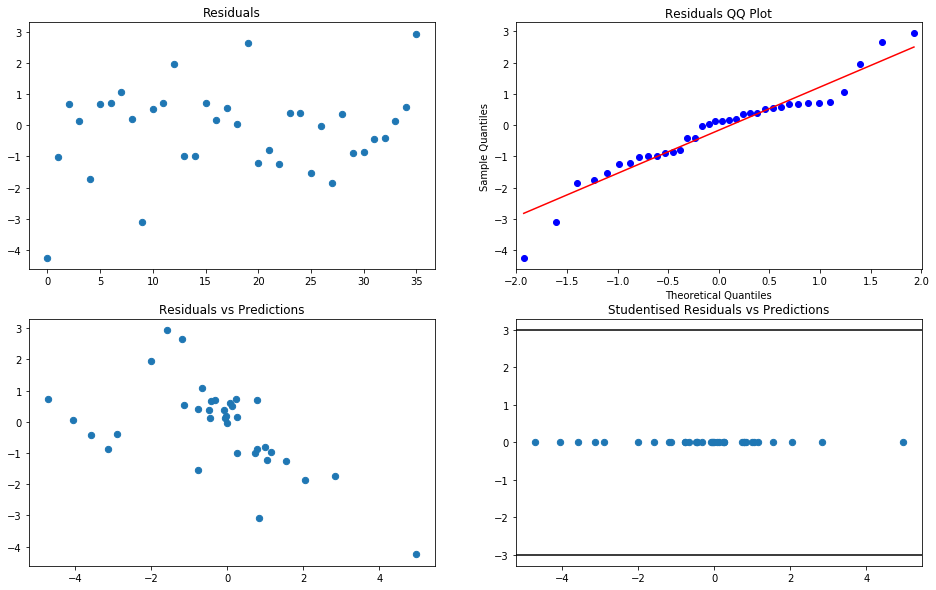

best model: 1 r2 score: 0.23


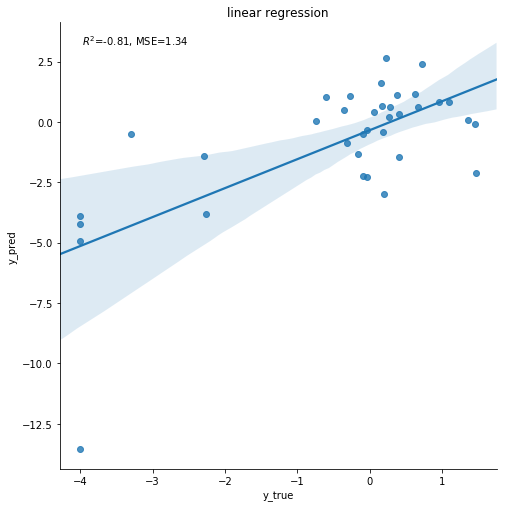

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


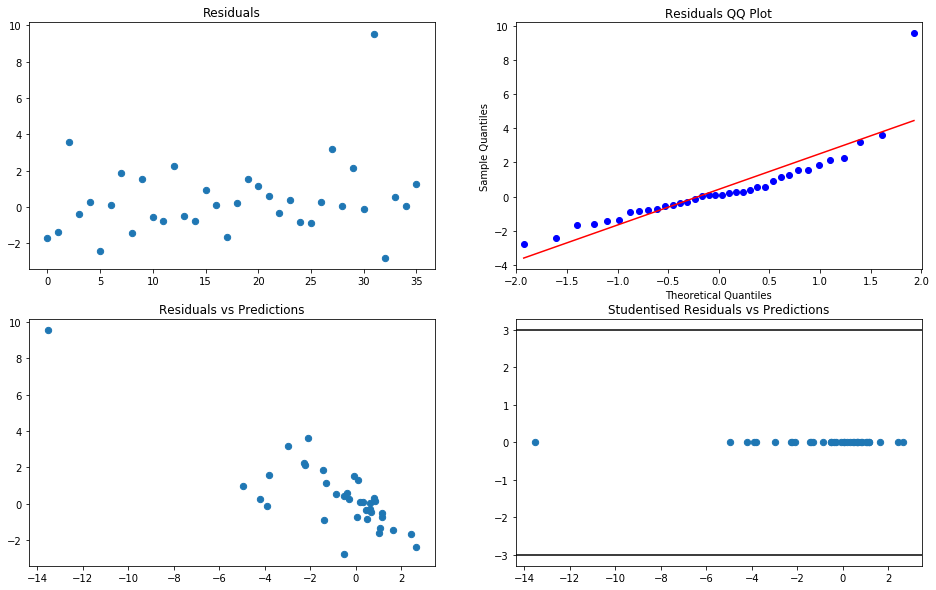

Average MSE for random forest regression model: 0.866 (+/- 0.247)
Average R2 for random forest regression model: 0.641 (+/- 0.085)


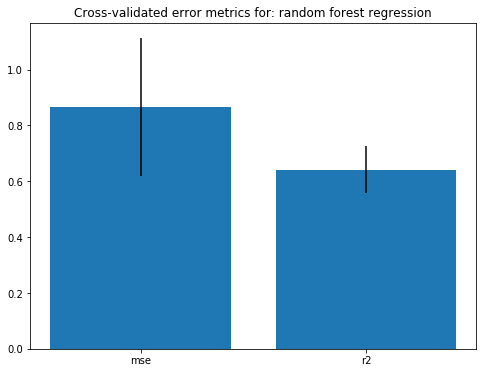

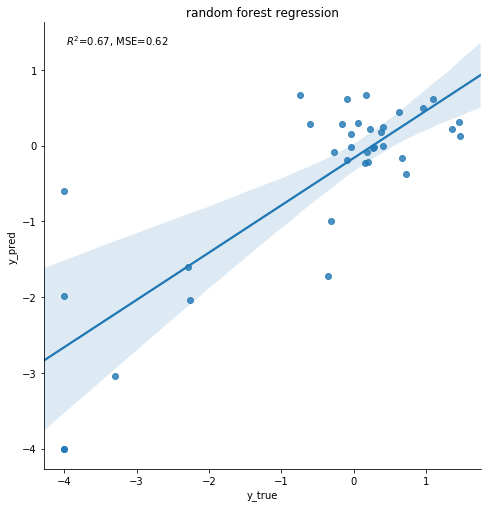

best model: 0 r2 score: 0.67


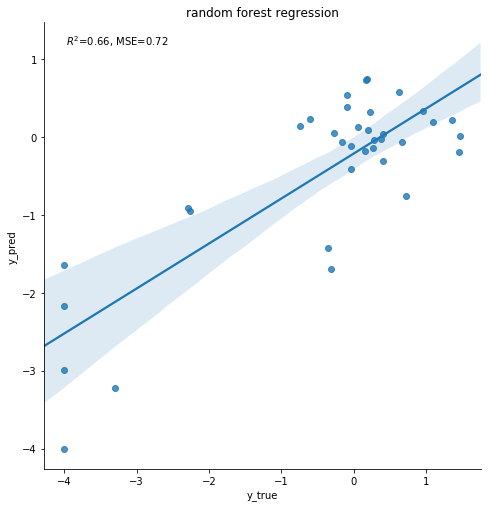

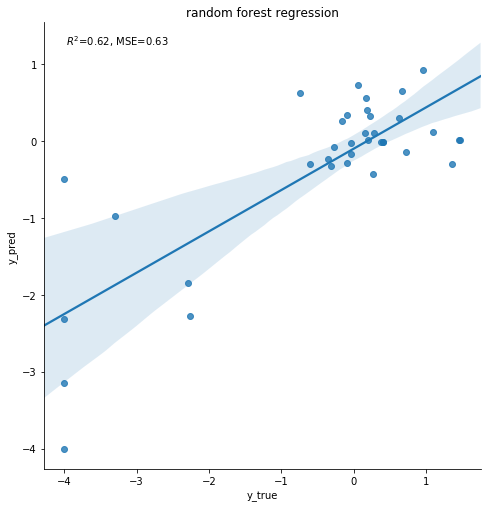

In [5]:
## Preprocessing 

# Normalisations scaling
scaler = preprocessing.StandardScaler()

## Model testing with cross-validation 
linear = linear_model.LinearRegression()
rf = RandomForestRegressor()

## Scoring metrics
metric = ['neg_mean_squared_error', 'r2']

def fit_model(X, y, model, model_name):
    clf = make_pipeline(scaler, model)
    scores = cross_validate(model, X, y, cv=3, scoring=metric, return_train_score=False, return_estimator=True)
    print("Average MSE for %s model: %0.3f (+/- %0.3f)" % (model_name, -1 * scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
    print("Average R2 for %s model: %0.3f (+/- %0.3f)" % (model_name, scores['test_r2'].mean(),scores['test_r2'].std()))
    means = []
    stds = []
    names = ['mse', 'r2']
    means.append(-1 * scores['test_neg_mean_squared_error'].mean())
    means.append(scores['test_r2'].mean())
    stds.append(-1 * scores['test_neg_mean_squared_error'].std())
    stds.append(scores['test_r2'].std())
    ## Error metric plots
    plt.figure(figsize=(8,6))
    plt.title("Cross-validated error metrics for: " + model_name)
    plt.bar(names, means, yerr=stds)
    plt.show()
    return scores

def plot_residuals(X_train, y_test, pred):
    residuals = y_test - pred
    res_df = pd.DataFrame(residuals)
    res_df.columns = ['residuals']
    res_squared = residuals ** 2
    rss = sum(res_squared)
    n = len(residuals)
    p = X_train.shape[1]
   # denom = 
    #print(rss, n, p, denom)
    rse = cmath.sqrt((rss/(n-p-1.0)))

    # studentised residuals
    res_df['studentised_residuals'] = res_df['residuals'] / rse

    fig, ax = plt.subplots(2,2, figsize=(16,10))
    ax[0,0].scatter(x=res_df.index.values, y=res_df['residuals'], s=40)
    ax[0,0].set_title("Residuals")
    sm.qqplot(residuals, line='s', ax=ax[0,1])
    ax[0,1].set_title("Residuals QQ Plot")
    ax[1,0].scatter(pred, res_df['residuals'], s=40)
    ax[1,0].set_title("Residuals vs Predictions")
    ax[1,1].scatter(pred,res_df['studentised_residuals'], s=40)
    ax[1,1].set_title("Studentised Residuals vs Predictions")
    ax[1,1].axhline(y=3, c='black')
    ax[1,1].axhline(y=-3, c='black')
    plt.show()
    
def evaluate_models(scores, X_test, y_test, name, return_best_estimator=True):
    best_r2 = 0
    best_mae = 0
    best_model = None
    #y_test.reset_index(inplace=True)
    for i in range(len(scores['estimator'])):
        model = scores['estimator'][i]
        pred = model.predict(X_test)
        test = pd.DataFrame(pred)
        test.columns = ['y_pred']
        test['y_true'] = y_test
        sns.pairplot(test, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
        plt.title(name)
        plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, pred), metrics.mean_absolute_error(y_test, pred)), xy=(0.05, 0.95), xycoords='axes fraction')
        plt.show()
        r2 = metrics.r2_score(y_test, pred)
        if name == 'linear regression':
            plot_residuals(X_test, y_test, pred)
        if r2 > best_r2:
            best_r2  = r2
            best_model = model
            print("best model: %s r2 score: %0.2f" % (i, best_r2))
    return best_model

lin_scores = fit_model(X_train, y_train, linear, 'linear regression')
lin_best = evaluate_models(lin_scores, X_test, y_test, 'linear regression')

rf_scores = fit_model(X_train, y_train, rf, 'random forest regression')
rf_best = evaluate_models(rf_scores, X_test, y_test, 'random forest regression')



## Random Forest Model Analysis

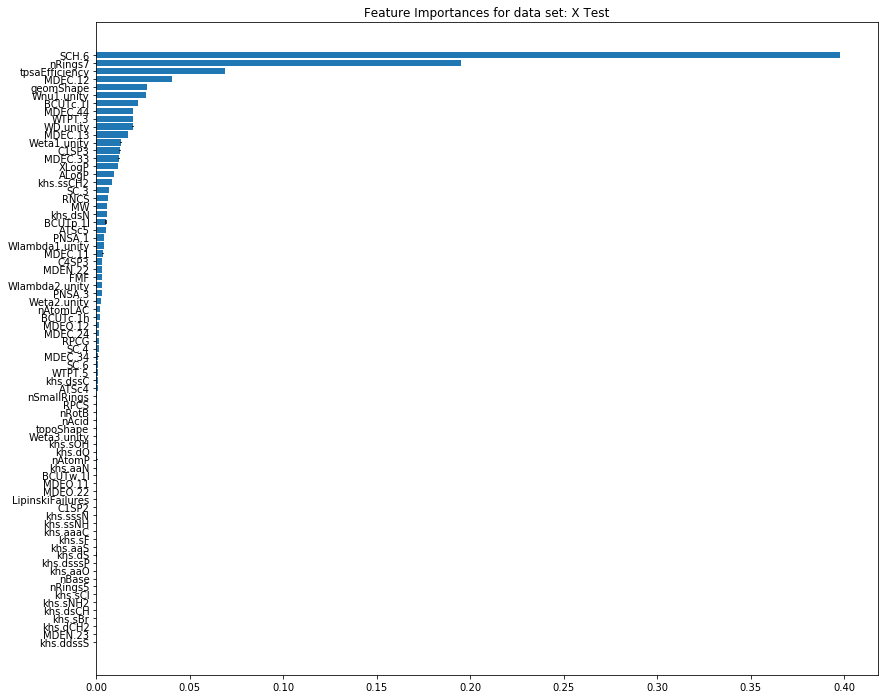

In [6]:
## Feature importance 

def rf_feature_importance(data, model, X, name):
    n_col = data.shape[1]
    features = data.columns[0:n_col]
    pred = model.predict(X)
    #m=RandomForestRegressor(n_estimators=50, oob_score=True,n_jobs=-1,bootstrap=True,random_state=42)
    rank = model.feature_importances_
    indices = np.argsort(model.feature_importances_)
    #top = rank[indices][:20]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    plt.figure(figsize=(14,12))
    plt.barh(range(len(indices)), rank[indices], align='center', yerr=std)
    plt.yticks(range(len(indices)), features[indices])
    plt.title('Feature Importances for data set: %s' % name)
    return rank, indices
    
df = pd.DataFrame(data)
rank, indices = rf_feature_importance(df, rf_best, X_test, "X Test")
#print("ranked: %s" % (rank[indices][:10]))

In [7]:
rf_best.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [8]:
from sklearn.model_selection import GridSearchCV

## Grid search of RF model parameters

## Random Forest parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4,5,6,7, 8]

}

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_r2'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_r2'][candidate],
                  results['std_test_r2'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Define scoring metrics

metric = ['neg_mean_squared_error', 'r2']

# Create a regressor object with the regressor and parameter candidates
clf = GridSearchCV(estimator=rf_best, param_grid=param_grid, n_jobs=-1, cv=3, iid=False, scoring=metric, refit='r2')

# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)
non_nested_scores = clf.best_score_

# Nested CV with parameter optimization
nested_scores = cross_val_score(clf, X=X_train, y=y_train, cv=3, scoring='r2')
score_difference = non_nested_scores - nested_scores

results = clf.cv_results_
#%%
print("Best parameters set found on training set:")
print()
print(report(results))
print()
print("nested scores: ", nested_scores)
print("non_nested_scores: ", non_nested_scores)
print("score difference: ", score_difference)

Best parameters set found on training set:

Model with rank: 1
Mean validation score: 0.675 (std: 0.107)
Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.675 (std: 0.113)
Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.673 (std: 0.113)
Parameters: {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}

None

nested scores:  [0.6947868  0.75754583 0.51756467]
non_nested_scores:  0.6748676839847606
score difference:  [-0.01991912 -0.08267814  0.15730301]


## Neural Network Models

### !! This section is not complete and needs more development/testing!!


In [9]:
# Initial hyperparameters were inspired by 
# "Development of QSAR models to predict and interpret the biological activity of artemisinin analogues"

# Best architecture: 10-5-1
# Sigmoid activation function 

model = tf.keras.Sequential([
# Adds a densely-connected layer with 10 units to the model:
keras.layers.Dense(10, activation='sigmoid', input_shape=(75,)),
# Add another:
keras.layers.Dense(5, activation='sigmoid'),
# Add a softmax layer with 10 output units:
keras.layers.Dense(1, activation='sigmoid')])

# Configure a model for mean-squared error regression.
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=30, 
                    callbacks=[early_stop], batch_size=10, verbose=0)

Instructions for updating:
Use tf.cast instead.


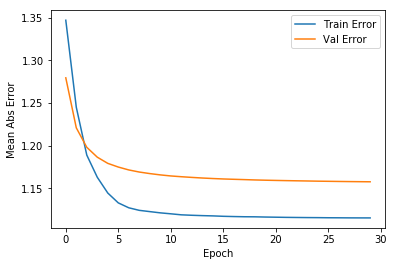

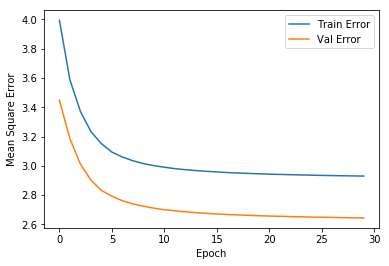

In [11]:

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

36/36 [==============================] - 0s 72us/sample - loss: 2.7052 - mean_absolute_error: 1.0459 - mean_squared_error: 2.7052
Test loss: 2.7051841947767468
Test accuracy: 1.0458919


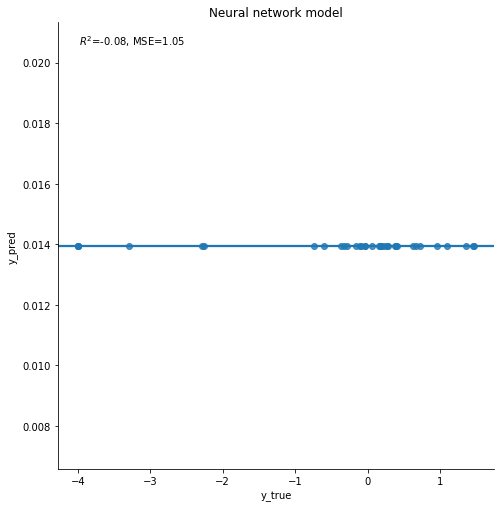

,y_pred,y_true
0,0.013948,0.72
1,0.013948,-0.28
2,0.013948,1.47
3,0.013948,0.06


In [12]:
# Predict

pred = model.predict(X_test).flatten()

test_scores = model.evaluate(X_test, y_test)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

test = pd.DataFrame(pred)
test.columns = ['y_pred']
test['y_true'] = y_test
sns.pairplot(test, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
plt.title("Neural network model")
plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, pred), metrics.mean_absolute_error(y_test, pred)), xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

test.head(4)